# Simple TOPFARM Example

This notebook walks through a minimal wind-farm design optimization that couples **OptiWindNet** (for wind farm electrical network optimization) with **[TopFarm](https://gitlab.windenergy.dtu.dk/TOPFARM)** (for wind farm layout optimization). For this purpose we will:


* **Build three cost components**:

  * Energy (AEP): we use PyWake to evaluate farm energy for a set of wind directions and turbine coordinates.
  * Electrical network (cabling): based on the data (coordiantes and cables) we build a cost model for cabling via a `WFNComponent` wrapper.
  * Economics (IRR / NPV): we create an `economic_evaluation` function and wrap it in a `CostModelComponent` that takes `AEP` and `cabling_cost` and outputs `IRR` (set as the optimization objective with `objective=True, maximize=True`).

**How it plugs into TopFarm**

1. We instantiate each component: `aep_comp`, `network_cost_comp`, and `npv_comp`.
2. We combine them in a `TopFarmGroup([aep_comp, network_cost_comp, npv_comp])`. With promotion, outputs/inputs line up automatically:

   * `aep_comp` produces **AEP** → used by the economic component.
   * `network_cost_comp` produces **cabling_cost** → also used by the economic component.
   * The economic component outputs **IRR**, which TopFarm treats as the **objective**.
3. We create a `TopFarmProblem` based on design variables (turbine positions), the defined cost component using `TopFarmGroup` (as mentiond above), constraints and driver.
4. Then we call `optimize()` in topfarm problem to run optimization

This setup yields a clean dataflow: `turbine positions → AEP & cabling_cost → IRR (objective)`. The constraints keep turbin layouts and the optimized electrical network feasible. The chosen router governs the electrical network quality/speed trade-off.

> **Note on boundaries and buffering**
>
> TopFarm’s gradient-based drivers occasionally move turbines a little outside the user-defined site polygon while searching the design space.
> OptiWindNet can accommodate these small excursions with
> `wfn.add_buffer(buff_dist=dist)`, which expands the outer border and shrinks any obstacle polygons by `dist` before it optimizes the electrical network.
>
> In this demo notebook we omit the border when we instantiate `WindFarmNetwork` because the rectangular site has no concavities or internal obstacles, and we don’t know in advance how far the topfarm driver might overshoot. In real projects (especially when the site has concavity or exclusion zones), the user should
>
> 1. **Estimate the maximum overshoot** the chosen TopFarm driver may produce (e.g. by running a few test iterations or inspecting previous layouts).
> 2. Call `wfn.add_buffer(buff_dist=max_overshoot)` *before* optimisation, or pass the buffered border/obstacles directly when creating the `WindFarmNetwork`.
>
> This ensures OptiWindNet always receives a feasible geometry, while keeping the electrical-network solution as much as possible consistent with the true site limits.


Import required packages

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.examples.hornsrev1_example import Hornsrev1Site
from py_wake import Nygaard_2022

from topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation
from topfarm.easy_drivers import EasySGDDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.constraint_components.constraint_aggregation import DistanceConstraintAggregation

from optiwindnet.api import WindFarmNetwork
from optiwindnet.augmentation import poisson_disc_filler

In [3]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Wind farm design parameters

Define turbine type and count:

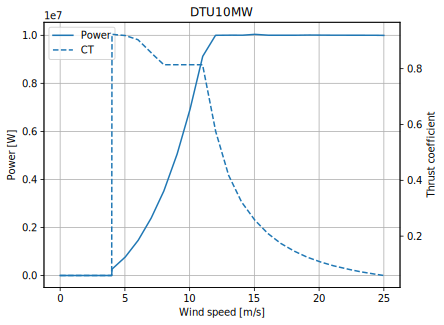

In [4]:
wind_turbines = DTU10MW()
n_wt = 20
wind_turbines.plot_power_ct();

Define the wind resource:

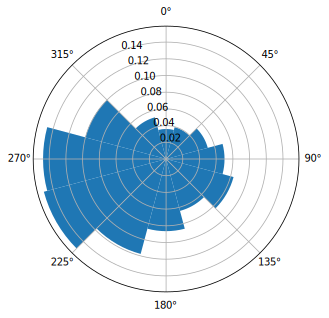

In [5]:
site = Hornsrev1Site()
site.plot_wd_distribution();

Define the area:

In [6]:
d_west_east = 4000  # [m] width
d_south_north = 2000  # [m] height
min_wt_spacing = 3.5*wind_turbines.diameter()  # [m] inter-turbine minimum distance
boundary = np.array([
    (0, 0),
    (d_west_east, 0),
    (d_west_east, d_south_north),
    (0, d_south_north)
])

Define the substation position:

In [7]:
x_ss, y_ss = (d_west_east/5, d_south_north/2)

## Initial wind farm layout (turbine positions)

In [ ]:
# Generate initial random turbine layout
x_init, y_init = poisson_disc_filler(
    n_wt,
    min_dist=min_wt_spacing,
    BorderC=boundary,
    seed=42,
    rounds=10,
).T

## Build components

### AEP component

In [9]:
# number of wind directions to consider
n_wd = 12

aep_comp = PyWakeAEPCostModelComponent(
    windFarmModel=Nygaard_2022(
        site=site,
        windTurbines=wind_turbines,
    ),
    n_wt=n_wt,
    wd=np.linspace(0.0, 360.0, n_wd, endpoint=False),
    objective=False,
)

### Electrical network component

#### Choose the router

Pick one of the available routers in OptiWindNet:

**EWRouter**

```python
from optiwindnet.api import EWRouter
router = EWRouter()
```

**HGSRouter**

```python
from optiwindnet.api import HGSRouter
router = HGSRouter(time_limit=0.1)  # seconds
```

**MILPRouter**

```python
from optiwindnet.api import MILPRouter
router = MILPRouter(
    solver_name='gurobi',  # or 'cplex', 'ortools'
    time_limit=1,          # seconds
    mip_gap=0.005,         # relative optimality gap (0.5%)
    verbose=True
)
```

> After choosing, pass `router` to `WindFarmNetwork(..., router=router)` through `WFNComponent`. If you use `MILPRouter`, make sure a supported solver is installed (and licensed if necessary).

Let's proceed with `MILPRouter` for this example. You can easily switch to other routers using the sample codes above.

In [11]:
from optiwindnet.api import MILPRouter
router = MILPRouter(solver_name='gurobi', time_limit=0.1, mip_gap=0.005)

Assemble initial turbine/substation positions in OptiWindNet format.

In [12]:
turbines_pos = np.column_stack((x_init, y_init))
substations_pos = np.column_stack((x_ss, y_ss))

Define cables.

In [13]:
cables = np.array([(2, 2000), (5, 2200)])

Build a Cost model for electrical network (cabling) optimizaiton

In [14]:
class WFNComponent(CostModelComponent):
    def __init__(self, turbines_pos, substations_pos, cables, router, borderC=boundary, **kwargs):
        self.wfn = WindFarmNetwork(
            turbinesC=turbines_pos,
            substationsC=substations_pos,
            cables=cables,
            router=router,)
            #borderC=boundary)

        def compute(x, y, xs, ys):
            self.wfn.optimize(turbinesC=np.column_stack((x, y)),
                              substationsC=np.column_stack((xs, ys)),
                              )
            return self.wfn.cost(), {
                'network_length': self.wfn.length(),
                'terse_links': self.wfn.terse_links(),
            }

        def compute_partials(x, y, xs, ys):
            grad_wt, grad_ss = self.wfn.gradient(
                turbinesC=np.column_stack((x, y)),
                substationsC=np.column_stack((xs, ys)),
            )
            dc_dx, dc_dy = grad_wt[:, 0], grad_wt[:, 1]
            dc_dxss, dc_dyss = grad_ss[:, 0], grad_ss[:, 1]
            return [dc_dx, dc_dy, dc_dxss, dc_dyss]

        x_init, y_init = turbines_pos.T
        x_ss_init, y_ss_init = substations_pos.T
        super().__init__(
            input_keys=[('x', x_init), ('y', y_init),
                        ('xs', x_ss_init), ('ys', y_ss_init)],
            n_wt=turbines_pos.shape[0],
            cost_function=compute,
            cost_gradient_function=compute_partials,
            objective=False,
            output_keys=[('cabling_cost', 0.0)],
            additional_output=[
                ('network_length', 0.0),
                ('terse_links', np.zeros(turbines_pos.shape[0])),
            ],
            **kwargs,
        )

Initialize the `WFNComponent` with input data.

In [15]:
network_cost_comp = WFNComponent(
    turbines_pos=turbines_pos,
    substations_pos=substations_pos,
    cables=cables,
    router=router,
)

### IRR - Internal Rate of Return component

In [16]:
fixed_economic_parameters = dict(
    rated_rpm_array=np.full((n_wt,), 12.0),
    D_rotor_array=np.full((n_wt,), wind_turbines.diameter()),
    Power_rated_array=np.full((n_wt,), wind_turbines.power(20.0)*1e-6),
    hub_height_array=np.full((n_wt,), wind_turbines.hub_height()),
    water_depth_array=np.full((n_wt,), 33.0),
)

In [17]:
eco_eval = economic_evaluation(
    distance_from_shore=30,  # [km]
    energy_price=0.06,        # [€/kWh] revenue
    project_duration=25,     # [years]
)

In [18]:
# Internal Rate of Return
def calc_irr(AEP, cabling_cost, **kwargs):
    return eco_eval.calculate_irr(
        **fixed_economic_parameters,
        aep_array=np.full((n_wt,), AEP/n_wt*10**6),
        cabling_cost=cabling_cost,
    )

In [19]:
# Economy
npv_comp = CostModelComponent(
    input_keys=[
        ('AEP', 0),
        ('cabling_cost', 0)
    ],
    n_wt=n_wt,
    # cost_function=calc_npv,
    cost_function=calc_irr,
    objective=True,
    maximize=True,
    # output_keys=[('NPV', 0)],
    output_keys=[('IRR', 0)],
)

## Build Topfarm problem

Defined a cost component using `TopFarmGroup` based on three cost components defined above.

In [20]:
cost_comp = TopFarmGroup([
    aep_comp,
    network_cost_comp,
    npv_comp,
])

Create a `TopFarmProblem` based on design variables (turbine positions), the defined cost component, constraints and driver.

In [21]:
tf_problem = TopFarmProblem(
    design_vars=dict(
        x=x_init,
        y=y_init,
    ),
    cost_comp=cost_comp,
    constraints=DistanceConstraintAggregation(
        XYBoundaryConstraint(boundary, 'polygon'),
        n_wt,
        min_wt_spacing,
        wind_turbines,
    ),
    driver=EasySGDDriver(maxiter=200),
    plot_comp=XYPlotComp(),
)

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.001575 sec).
INFO: checking system...
INFO:     system check complete (0.000123 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000268 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000054 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000034 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000678 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000092 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000005 sec).


## Run optimization.

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000254 sec).
INFO: checking system...
INFO:     system check complete (0.000014 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000194 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000193 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000012 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000287 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000071 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000007 sec).


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


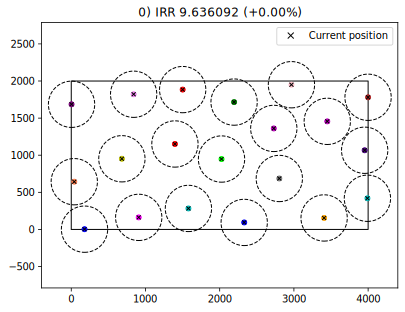

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Optimized in	86.757s


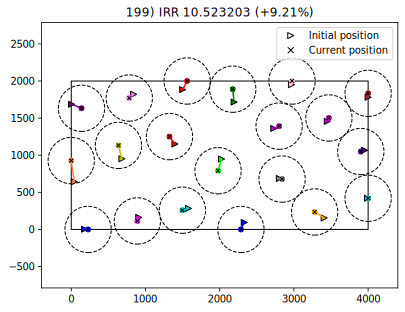

In [22]:
cost, state, recorder = tf_problem.optimize(disp=True)

## Plotting
In this section we monitor AEP, cabling_cost, IRR, and constraint_violation over time.

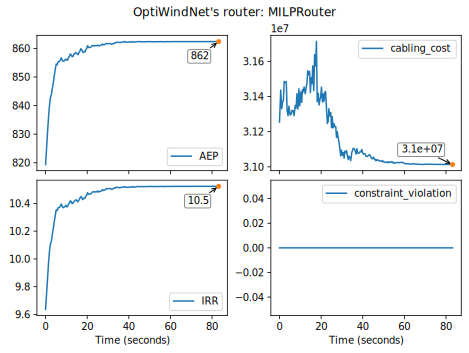

In [23]:
records_to_plot = ['AEP', 'cabling_cost', 'IRR', 'constraint_violation']
time = recorder['timestamp'] - recorder['timestamp'][0]
fig, axs = plt.subplots(math.ceil(len(records_to_plot)/2), 2, sharex=True, layout='constrained')


pos_final_values = [
    dict(offset=(-10, -10), ha='right', va='top'),
    dict(offset=(-10, 10), ha='right', va='bottom'),
    dict(offset=(-10, -10), ha='right', va='top'),
    None
]

for i, (ax, key) in enumerate(zip(axs.ravel(), records_to_plot)):
    line, = ax.plot(time, recorder[key], label=key)
    ax.legend()

    pos = pos_final_values[i] if i < len(pos_final_values) else None
    if pos is None:
        break

    # last point
    x_last = line.get_xdata()[-1]
    y_last = line.get_ydata()[-1]
    ax.plot(x_last, y_last, 'o', ms=4)

    ax.annotate(
        f"{y_last:.3g}",
        xy=(x_last, y_last),
        xytext=pos['offset'], textcoords='offset points',
        ha=pos['ha'], va=pos['va'],
        arrowprops=dict(arrowstyle='->', lw=1),
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='0.5', alpha=0.9),
    )

# label bottom subplots
for ax in axs[-1, :]:
    ax.set_xlabel("Time (seconds)")

router_name = type(router).__name__ 
sub_title = fig.suptitle(f"OptiWindNet's router: {router_name}")

Plot the optimized network for final wind farm layout.

<Axes: >

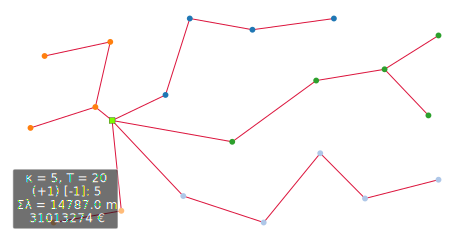

In [24]:
network_cost_comp.wfn.plot()